In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyrex
import pyrex.custom.ara as ara

The setup of the detector and event can be the same as the `Examine Event` notebook

In [2]:
det = ara.HexagonalGrid(station_type=ara.RegularStation,
                        stations=1, lowest_antenna=-100)
det.build_antennas(power_threshold=-6.15)

In [3]:
p = pyrex.Particle(particle_id=pyrex.Particle.Type.electron_neutrino,
                   vertex=[1002.65674195, -421.95118348, -586.0953201],
                   direction=[-0.90615395, -0.41800062, -0.06450191],
                   energy=1e9)
p.interaction.kind = p.interaction.Type.charged_current
p.interaction.em_frac = 1
p.interaction.had_frac = 0
gen = pyrex.ListGenerator(pyrex.Event(p))
# kern = pyrex.EventKernel(antennas=det, generator=gen)

In order to get the waveforms before the antennas, we need to take code from the `EventKernel` and only run part of it.

The entire code of `EventKernel.event()` is below, with the parts we won't need commented out and variable names changed to match the variables we have from above or default values of the `EventKernel`.

I've also added arrays `propagated_waveforms_spol` and `propagated_waveforms_ppol` to store the s- and p-polarized waveforms at each antenna.

In [4]:
event = gen.create_event()
ray_paths = []
polarizations = []
propagated_waveforms_spol = []
propagated_waveforms_ppol = []
for i in range(len(det)):
    ray_paths.append([])
    polarizations.append([])
for particle in event:
#     logger.info("Processing event for %s", particle)
#     if isinstance(self.weight_min, Sequence):
#         if ((particle.survival_weight is not None and
#                 particle.survival_weight<self.weight_min[0]) or
#                 (particle.interaction_weight is not None and
#                  particle.interaction_weight<self.weight_min[1])):
#             logger.debug("Skipping particle with weight below %s",
#                          self.weight_min)
#             continue
#     elif particle.weight<self.weight_min:
#         logger.debug("Skipping particle with weight below %s",
#                      self.weight_min)
#         continue

    for i, ant in enumerate(det):
        rt = pyrex.RayTracer(particle.vertex, ant.position,
                             ice_model=pyrex.ice)

        # If no path(s) between the points, skip ahead
        if not rt.exists:
#             logger.debug("Ray paths to %s do not exist", ant)
            continue

        theta_c = np.arccos(1/pyrex.ice.index(particle.vertex[2]))

        ray_paths[i].extend(rt.solutions)
        for path in rt.solutions:
            # nu_pol is the signal polarization at the neutrino vertex
            # It's calculated as the (negative) vector rejection of
            # path.emitted_direction onto particle.direction, making
            # epol orthogonal to path.emitted_direction in the same
            # plane as particle.direction and path.emitted_direction
            # This is equivalent to the vector triple product
            # (particle.direction x path.emitted_direction) x
            # path.emitted_direction
            # In the case when path.emitted_direction and
            # particle.direction are equal, just let nu_pol be zeros
            nu_pol = pyrex.internal_functions.normalize(np.vdot(path.emitted_direction,
                                                                particle.direction)
                                                        * path.emitted_direction
                                                        - particle.direction)
            polarizations[i].append(nu_pol)

            psi = np.arccos(np.vdot(particle.direction,
                                    path.emitted_direction))
#             logger.debug("Angle to %s is %f degrees", ant,
#                          np.degrees(psi))

            try:
#                 if np.abs(psi-theta_c)>self.offcone_max:
#                     raise ValueError("Viewing angle is larger than "+
#                                      "offcone limit "+
#                                      str(np.degrees(self.offcone_max)))
                pulse = pyrex.AskaryanSignal(
                    times=np.linspace(-50e-9, 50e-9, 2000, endpoint=False),
                    particle=particle,
                    viewing_angle=psi,
                    viewing_distance=path.path_length,
                    ice_model=pyrex.ice
                )
            except ValueError as err:
                logger.debug("Eliminating invalid Askaryan signal: %s",
                             err)
                ant.receive(
                    EmptySignal(np.linspace(-50e-9, 50e-9, 2000, endpoint=False)+path.tof,
                                value_type=EmptySignal.Type.field)
                )
            else:
                ant_pulses, ant_pols = path.propagate(
                    signal=pulse, polarization=nu_pol,
                    attenuation_interpolation=0.1
                )
                propagated_waveforms_spol.append(ant_pulses[0])
                propagated_waveforms_ppol.append(ant_pulses[1])
#                 ant.receive(
#                     ant_pulses,
#                     direction=path.received_direction,
#                     polarization=ant_pols
#                 )

# if self.triggers is None:
#     triggered = None
# elif isinstance(self.triggers, dict):
#     triggered = {key: trigger_func(self.antennas)
#                  for key, trigger_func in self.triggers.items()}
# else:
#     triggered = self.triggers(self.antennas)

# if self.writer is not None:
#     self.writer.add(event=event, triggered=triggered,
#                     ray_paths=ray_paths, polarizations=polarizations,
#                     events_thrown=self.gen.count-self._gen_count)

# self._gen_count = self.gen.count

# if triggered is None:
#     return event
# elif isinstance(self.triggers, dict):
#     return event, triggered['global']
# else:
#     return event, triggered

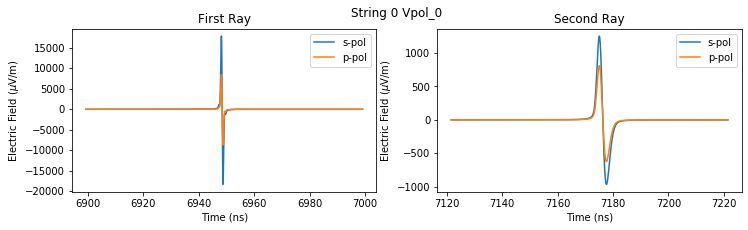

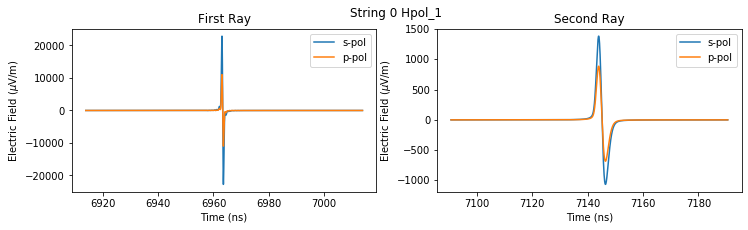

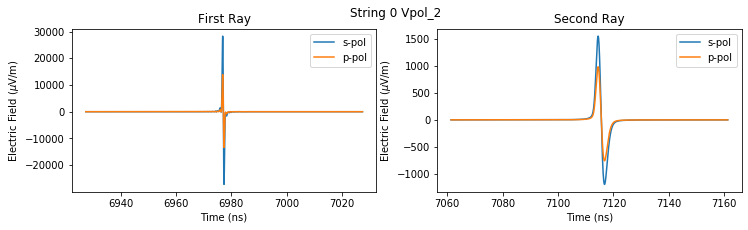

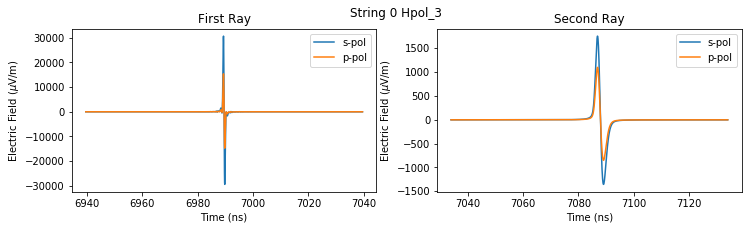

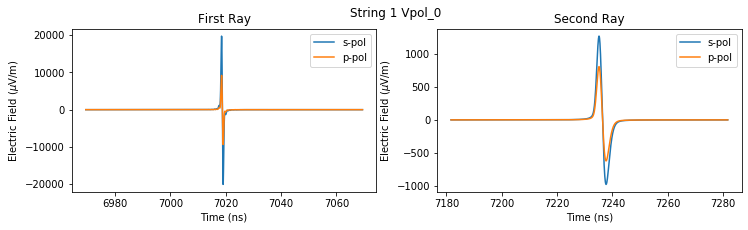

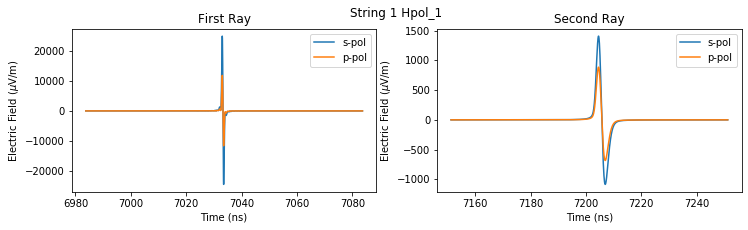

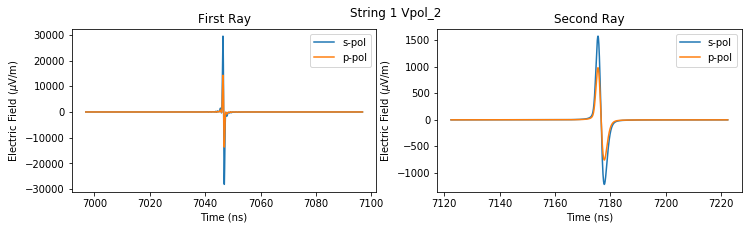

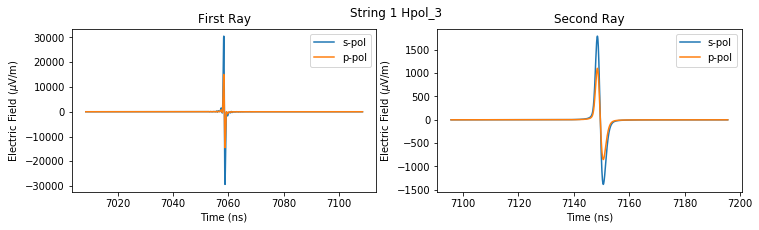

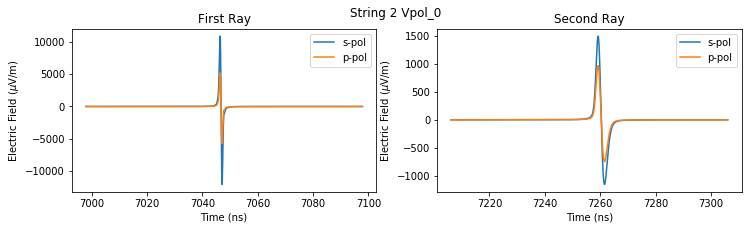

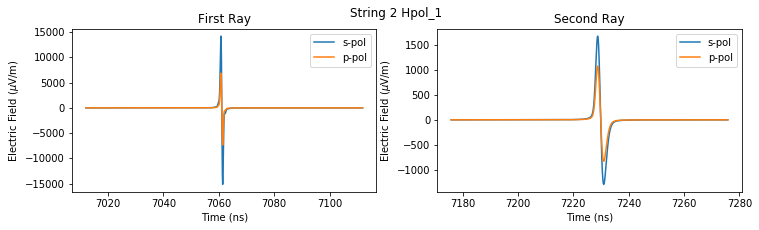

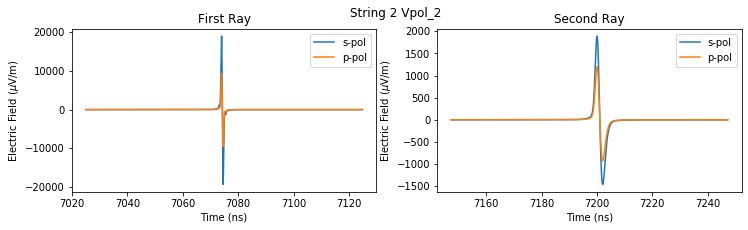

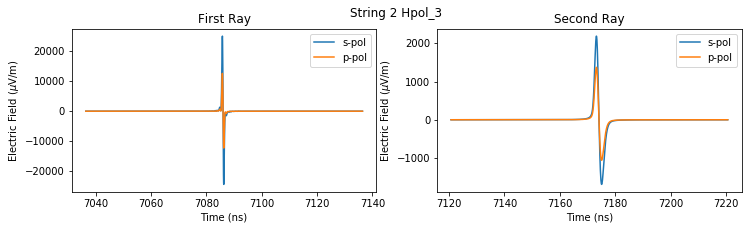

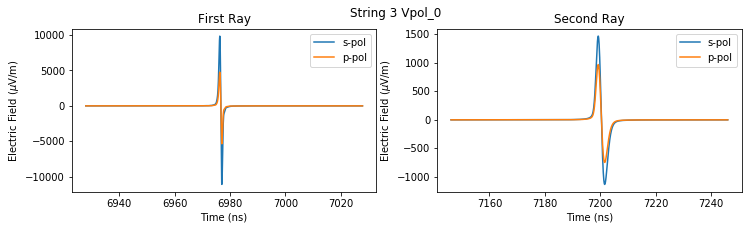

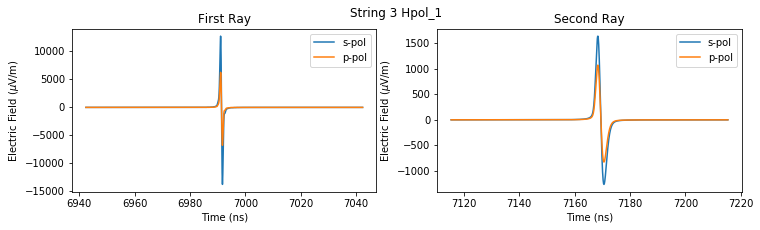

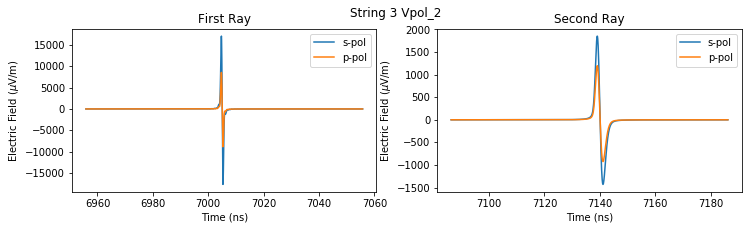

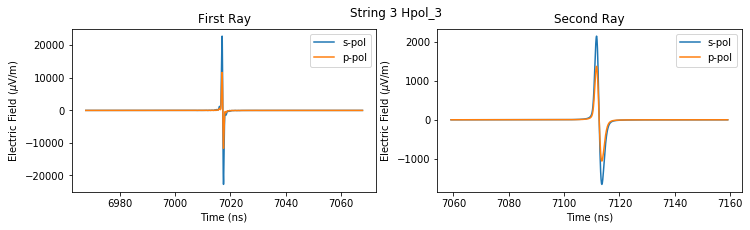

In [5]:
for i, ant in enumerate(det):
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    spol_dir = propagated_waveforms_spol[2*i]
    spol_ref = propagated_waveforms_spol[2*i+1]
    ppol_dir = propagated_waveforms_ppol[2*i]
    ppol_ref = propagated_waveforms_ppol[2*i+1]
    ax[0].plot(spol_dir.times*1e9, spol_dir.values*1e6, label='s-pol')
    ax[0].plot(ppol_dir.times*1e9, ppol_dir.values*1e6, label='p-pol')
    ax[0].legend()
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Electric Field ($\\mu$V/m)")
    ax[0].set_title("First Ray")
    ax[1].plot(spol_ref.times*1e9, spol_ref.values*1e6, label='s-pol')
    ax[1].plot(ppol_ref.times*1e9, ppol_ref.values*1e6, label='p-pol')
    ax[1].legend()
    ax[1].set_xlabel("Time (ns)")
    ax[1].set_ylabel("Electric Field ($\\mu$V/m)")
    ax[1].set_title("Second Ray")
    fig.suptitle("String "+str(int(i/4))+" "+ant.name)
    plt.show()

Like we have discussed, the propagation in PyREx handles s-polarized and p-polarized parts of the waveform separately, so at this point each ray has two independently polarized waveforms.

When we did the comparison to AraSim I had to rework this and just propagate the original waveform without handling the polarization. The hack around that is to drop the polarization info from the `path.propagate` method, and then the ray tracer will naiively propagate the ray without any concern for the polarization. This is less physical, but maybe what you were looking for so I'll include it here:

In [6]:
event = gen.create_event()
ray_paths = []
polarizations = []
propagated_waveforms = []
for i in range(len(det)):
    ray_paths.append([])
    polarizations.append([])
for particle in event:
#     logger.info("Processing event for %s", particle)
#     if isinstance(self.weight_min, Sequence):
#         if ((particle.survival_weight is not None and
#                 particle.survival_weight<self.weight_min[0]) or
#                 (particle.interaction_weight is not None and
#                  particle.interaction_weight<self.weight_min[1])):
#             logger.debug("Skipping particle with weight below %s",
#                          self.weight_min)
#             continue
#     elif particle.weight<self.weight_min:
#         logger.debug("Skipping particle with weight below %s",
#                      self.weight_min)
#         continue

    for i, ant in enumerate(det):
        rt = pyrex.RayTracer(particle.vertex, ant.position,
                             ice_model=pyrex.ice)

        # If no path(s) between the points, skip ahead
        if not rt.exists:
#             logger.debug("Ray paths to %s do not exist", ant)
            continue

        theta_c = np.arccos(1/pyrex.ice.index(particle.vertex[2]))

        ray_paths[i].extend(rt.solutions)
        for path in rt.solutions:
            # nu_pol is the signal polarization at the neutrino vertex
            # It's calculated as the (negative) vector rejection of
            # path.emitted_direction onto particle.direction, making
            # epol orthogonal to path.emitted_direction in the same
            # plane as particle.direction and path.emitted_direction
            # This is equivalent to the vector triple product
            # (particle.direction x path.emitted_direction) x
            # path.emitted_direction
            # In the case when path.emitted_direction and
            # particle.direction are equal, just let nu_pol be zeros
            nu_pol = pyrex.internal_functions.normalize(np.vdot(path.emitted_direction,
                                                                particle.direction)
                                                        * path.emitted_direction
                                                        - particle.direction)
            polarizations[i].append(nu_pol)

            psi = np.arccos(np.vdot(particle.direction,
                                    path.emitted_direction))
#             logger.debug("Angle to %s is %f degrees", ant,
#                          np.degrees(psi))

            try:
#                 if np.abs(psi-theta_c)>self.offcone_max:
#                     raise ValueError("Viewing angle is larger than "+
#                                      "offcone limit "+
#                                      str(np.degrees(self.offcone_max)))
                pulse = pyrex.AskaryanSignal(
                    times=np.linspace(-50e-9, 50e-9, 2000, endpoint=False),
                    particle=particle,
                    viewing_angle=psi,
                    viewing_distance=path.path_length,
                    ice_model=pyrex.ice
                )
            except ValueError as err:
                logger.debug("Eliminating invalid Askaryan signal: %s",
                             err)
                ant.receive(
                    EmptySignal(np.linspace(-50e-9, 50e-9, 2000, endpoint=False)+path.tof,
                                value_type=EmptySignal.Type.field)
                )
            else:
#                 ant_pulses, ant_pols = path.propagate(
#                     signal=pulse, polarization=nu_pol,
#                     attenuation_interpolation=0.1
#                 )
#                 propagated_waveforms_spol.append(ant_pulses[0])
#                 propagated_waveforms_ppol.append(ant_pulses[1])
                ant_pulse = path.propagate(
                    signal=pulse,
                    attenuation_interpolation=0.1
                )
                propagated_waveforms.append(ant_pulse)
#                 ant.receive(
#                     ant_pulses,
#                     direction=path.received_direction,
#                     polarization=ant_pols
#                 )

# if self.triggers is None:
#     triggered = None
# elif isinstance(self.triggers, dict):
#     triggered = {key: trigger_func(self.antennas)
#                  for key, trigger_func in self.triggers.items()}
# else:
#     triggered = self.triggers(self.antennas)

# if self.writer is not None:
#     self.writer.add(event=event, triggered=triggered,
#                     ray_paths=ray_paths, polarizations=polarizations,
#                     events_thrown=self.gen.count-self._gen_count)

# self._gen_count = self.gen.count

# if triggered is None:
#     return event
# elif isinstance(self.triggers, dict):
#     return event, triggered['global']
# else:
#     return event, triggered

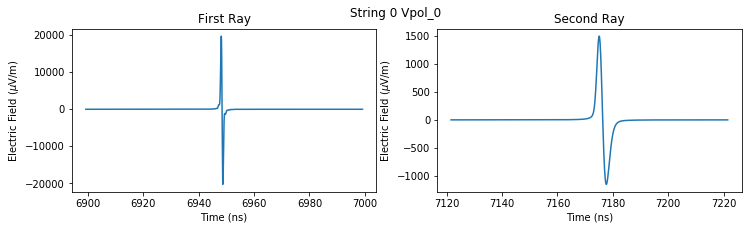

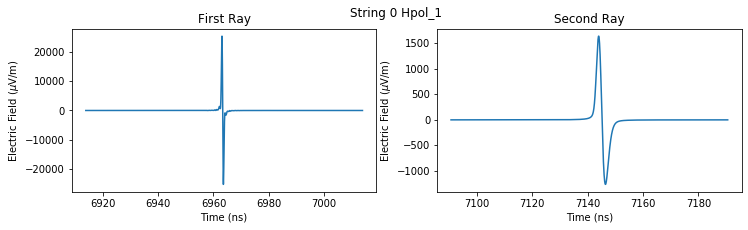

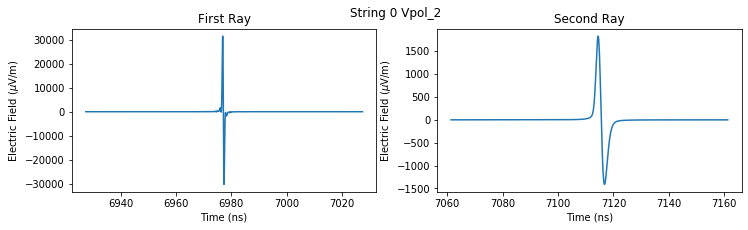

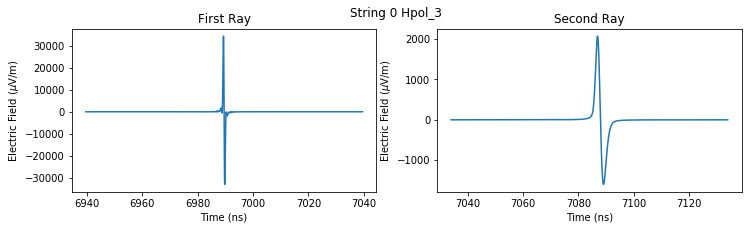

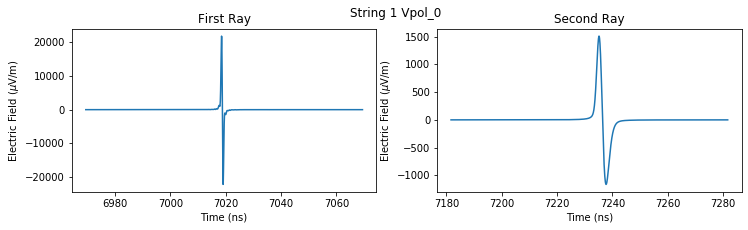

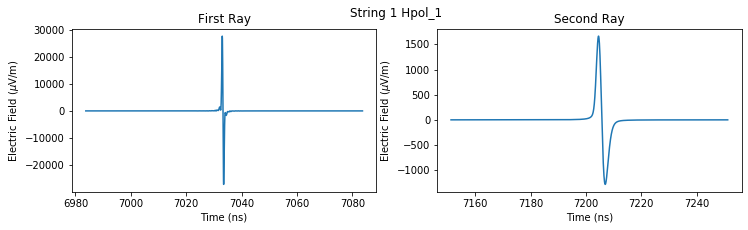

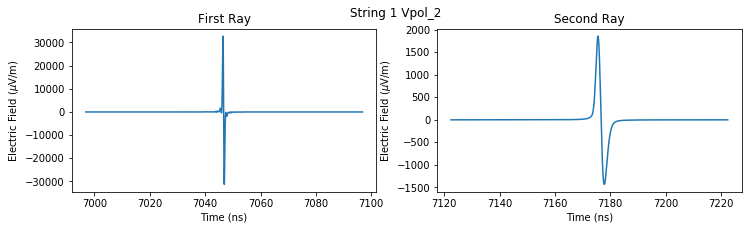

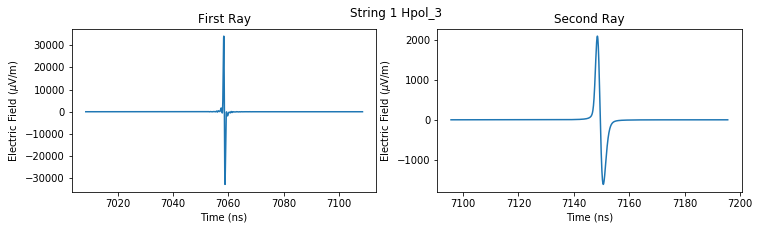

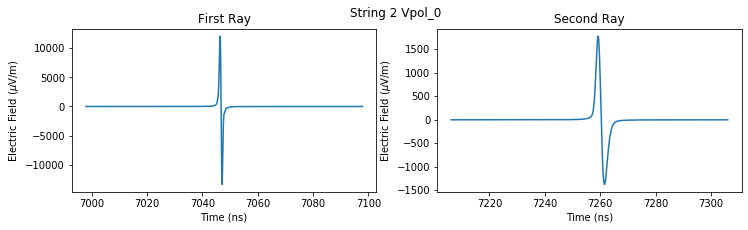

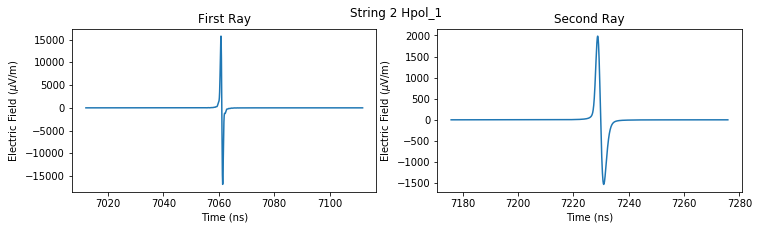

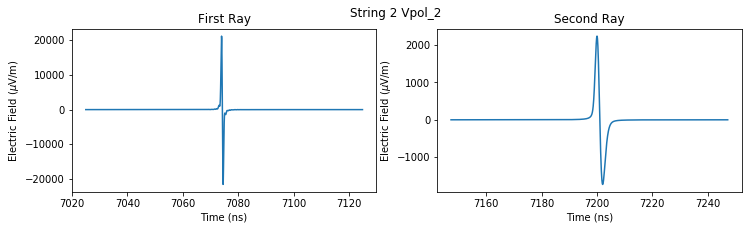

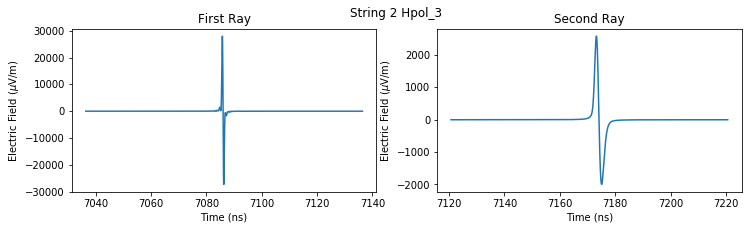

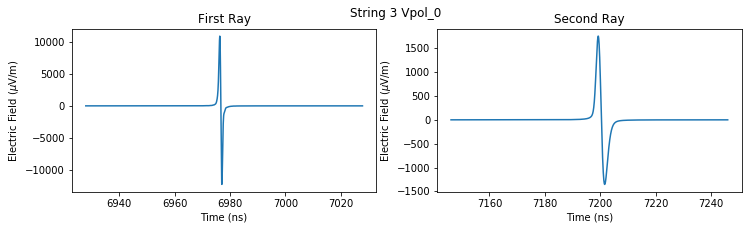

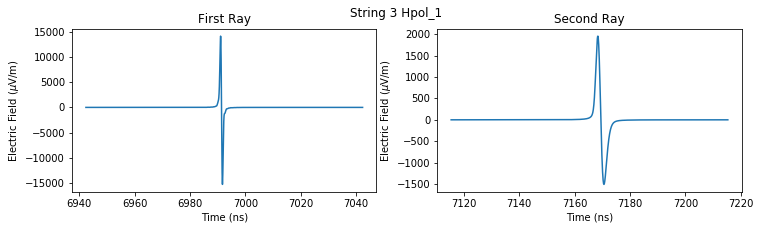

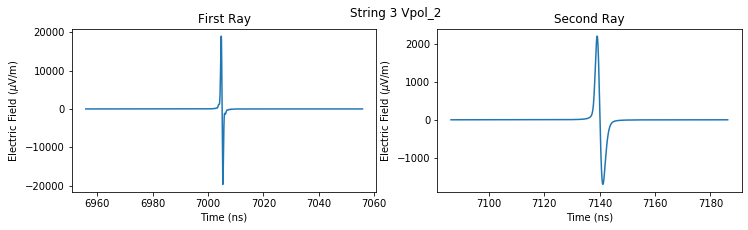

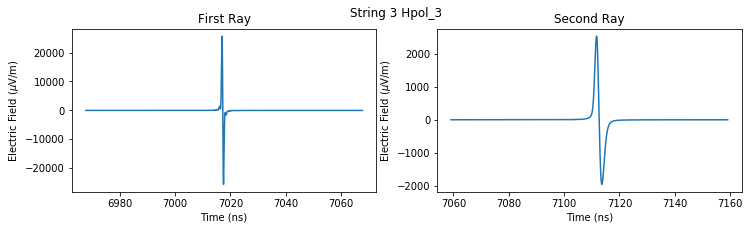

In [7]:
for i, ant in enumerate(det):
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    wave_dir = propagated_waveforms[2*i]
    wave_ref = propagated_waveforms[2*i+1]
    ax[0].plot(wave_dir.times*1e9, wave_dir.values*1e6)
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Electric Field ($\\mu$V/m)")
    ax[0].set_title("First Ray")
    ax[1].plot(wave_ref.times*1e9, wave_ref.values*1e6)
    ax[1].set_xlabel("Time (ns)")
    ax[1].set_ylabel("Electric Field ($\\mu$V/m)")
    ax[1].set_title("Second Ray")
    fig.suptitle("String "+str(int(i/4))+" "+ant.name)
    plt.show()